# Flux1 quantization inference with alimama inpainting controlnet and trained lora
In here we use the controlnet from alimama to do some tests on the trained lora and with quantization of the base model. The results are saved in the output folder, and can be stored in Google Drive if needed. However, autenticating with Google Drive is not possible when developing on a remote server.

In [1]:
import torch
from controlnet_flux import FluxControlNetModel
from transformer_flux import FluxTransformer2DModel
from pipeline_flux_controlnet_inpaint import FluxControlNetInpaintingPipeline
from diffusers.utils import load_image
from optimum.quanto import freeze, qint4, quantize
# from lycoris import create_lycoris_from_weights

# Build pipeline
controlnet = FluxControlNetModel.from_pretrained("alimama-creative/FLUX.1-dev-Controlnet-Inpainting-Beta", torch_dtype=torch.bfloat16)
transformer = FluxTransformer2DModel.from_pretrained(
        "black-forest-labs/FLUX.1-dev", subfolder='transformer', torch_dytpe=torch.bfloat16
    )
pipe = FluxControlNetInpaintingPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-dev",
    controlnet=controlnet,
    transformer=transformer,
    torch_dtype=torch.bfloat16
)

adapter_id = "/home/vlad/joiishop.products.training/FLUX-Controlnet-Inpainting/loras"
controlnet_inpainting = ""
lora_scale = 1.0
# wrapper, _ = create_lycoris_from_weights(lora_scale, adapter_id, pipe.transformer)
# wrapper.merge_to()

quantize(pipe.transformer, weights=qint4)
freeze(pipe.transformer)
quantize(pipe.text_encoder, weights=qint4)
freeze(pipe.text_encoder)
# pipe.to("cuda")

pipe.load_lora_weights(adapter_id, weighnt_name="pytorch_lora_weights.safetensors", adapter_name="CFT-F80")
pipe.set_adapters(["CFT-F80"], adapter_weights=[1.0])
pipe.fuse_lora(adapter_names=["CFT-F80"], lora_scale=1.2)

pipe.enable_model_cpu_offload() #save some VRAM by offloading the model to CPU. Remove this if you have enough GPU power

image_path = "./image.png"
mask_path = "./masked.png"

prompt = "A photo of a CDS-200 cloud sofa in a living room"
# Load image and mask
size = (768, 768)
image = load_image(image_path).convert("RGB").resize(size)
mask = load_image(mask_path).convert("RGB").resize(size)
generator = torch.Generator(device="cuda").manual_seed(24)

image = pipe(
            prompt=prompt,
            control_image=image,
            control_mask=mask,
            num_inference_steps=28,
            generator=generator,
            controlnet_conditioning_scale=0.9,
            guidance_scale=3.5,
            negative_prompt="",
            true_guidance_scale=3.5,
            height=1024,
            width=1024,
            max_sequence_length=512
            ).images[0]
image


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

/home/vlad/miniconda3/envs/flux/lib/python3.10/site-packages/diffusers/models/attention_processor.py:4282: FutureWarning: `FluxSingleAttnProcessor2_0` is deprecated and will be removed in version 0.32.0. `FluxSingleAttnProcessor2_0` is deprecated and will be removed in a future version. Please use `FluxAttnProcessor2_0` instead.
  deprecate("FluxSingleAttnProcessor2_0", "0.32.0", deprecation_message)


: 

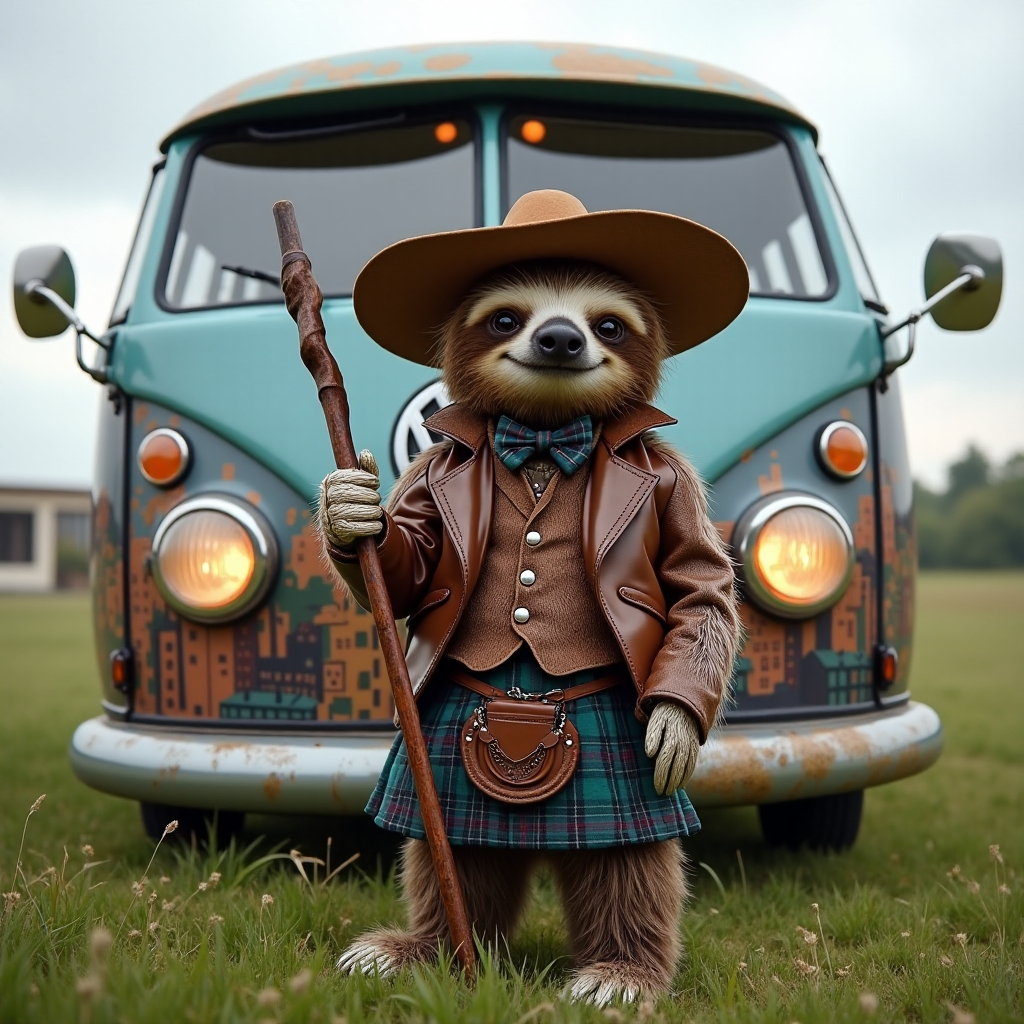

In [6]:
image

# SimpleTuner

Need to run the following from a terminal before running these cells
```bash
git clone https://github.com/nikgli/SimpleTuner.git
cd SimpleTuner
conda create -n SimpleTuner python=3.11 -y
conda activate SimpleTuner
```

In [ ]:
# Finishing up SimpleTuner installation
!pip install -U poetry pip

# Necessary on some systems to prevent it from deciding it knows better than us.
!poetry config virtualenvs.create false

!poetry install

## Configuraion
Either run 
```bash
python configure.py
```
Or copy config.json, lycoris_config.json and multidatabackend.json